In [1]:
# ======== importing modules ========
from pytransit import MandelAgol
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.nan)
import pandas as pd

fs = 22; ms = 4 #fontsize, markersize

#========== Karen's inverse weighted binning function =======
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time)) # finding where values are finite and "Not a Number (NaN)" or +/- infinite (inf)
    timefit = time[good] 
    fluxfit = flux[good] #using indices where values are finite, find where times, flux and errors are also finite
    errfit  = error[good]
    timemax = np.max(timefit) #find max time (or last time measurement)
    timemin = np.min(timefit) #find min time (or first time measurement)
    npoints = len(timefit)    #find number of data points
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days to nearest interger
    bintime = np.full((nbins,), np.nan) 
    binflux = np.full((nbins,), np.nan) #creating an empty array full of NaNs to fill in below
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )] #with given binsize, searching over smaller areas (aka windows) (t-window) to (t+window)
        if tobin[0] != -1:
    #     inverse variance weighted means; read about here: https://en.wikipedia.org/wiki/Inverse-variance_weighting
    
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime)) #checking again for NaNs and infs that might be created by previous step
    bintime = bintime[good2]
    binflux = binflux[good2] 
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr #here you have binned data with averaged values based on the bin sizes you've selected


def bin_and_clip(data,binsize,Nsig): #this definition simply bins the data and cuts out outliers

    d = np.transpose(np.loadtxt(data))
    t = d[0]
    m = d[1]/np.nanmean(d[1]) #normalized
    mag_mean = np.array(pd.DataFrame(m).rolling(15).mean())
    e = d[2]

    f = 10.0**(m/-2.5)/np.mean(10.0**(mag_mean/-2.5)) #converting from mag to flux and normalizing

    bint,binm,binfe = Bin_func(t,mag_mean,e, binsize) #binning data
    binf = 10.0**(binm/-2.5)/np.mean(10.0**(binm/-2.5))

    cut = np.where(binf< (np.mean(binf)+np.std(binf)))[0] #cutting ONLY data above 1 std above the mean

    return bint[cut],binf[cut],binfe[cut]


def GLS(time,flux,fluxerror):
    from PyAstronomy.pyTiming import pyPeriod
    # Compute the GLS periodogram with default options.
    # Choose Zechmeister-Kuerster normalization explicitly
    
    clp = pyPeriod.Gls((time, flux, fluxerror), norm="ZK", verbose=True)
#     clp = pyPeriod.Gls((time, flux, fluxerror), norm="chisq", verbose=True)    

    # Get index associated with highest power
    ifmax = np.argmax(clp.power)
    # and highest power and associated frequency
    pmax = clp.power[ifmax]
    fmax = clp.freq[ifmax]
    # Convert frequency into period
    hpp = 1./fmax
#     print("Highest-power period: ", hpp)

    # Calculate sine wave associated with 'best-fit' frequency
    bestSine = clp.sinmod(time)
    
    return bestSine, 1./fmax

In [2]:
#------------------------------Finding Downloaded TESS Data Files --------------------------------------
path = '/Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean' #location of where I put downloaded files

data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print "number of files: ",len(data) #number of files

# for d in range(len(data)):
#     print "data set #", d+1 ," : ", data[d] #I added the d+1 because python does zero-indexing (https://en.wikipedia.org/wiki/Zero-based_numbering)
#     print ""

number of files:  10138


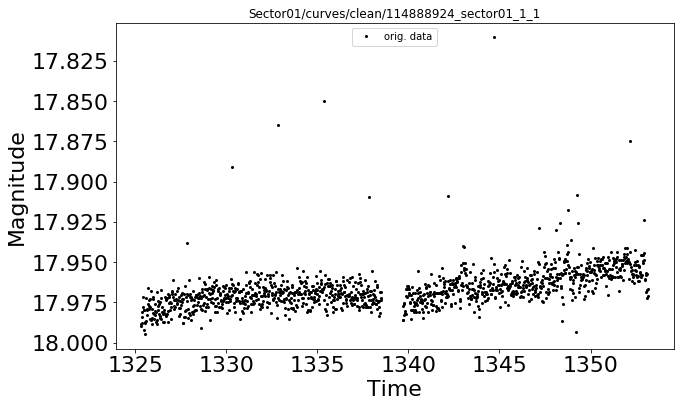

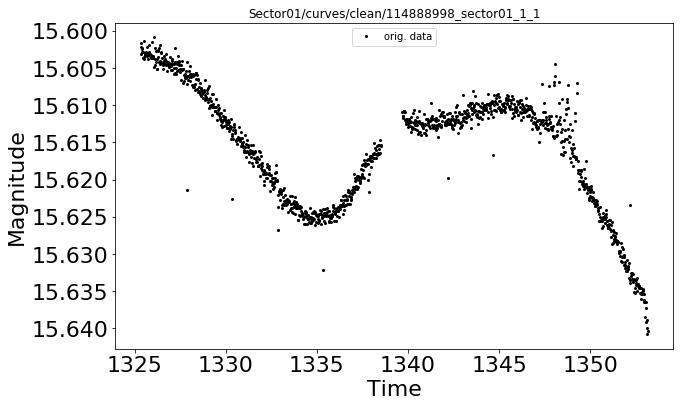

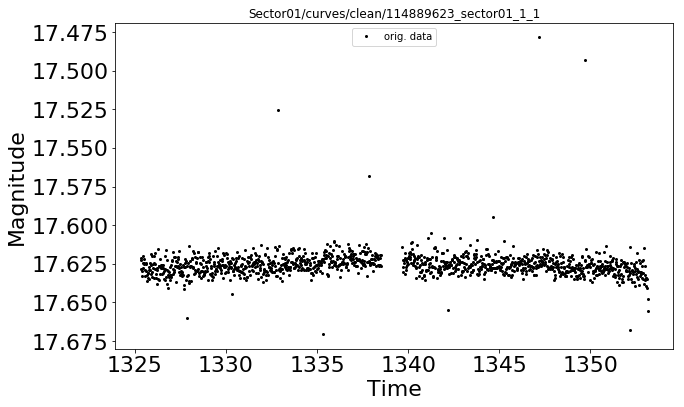

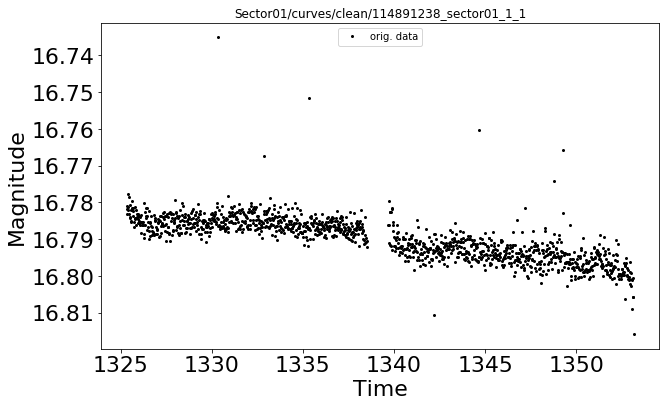

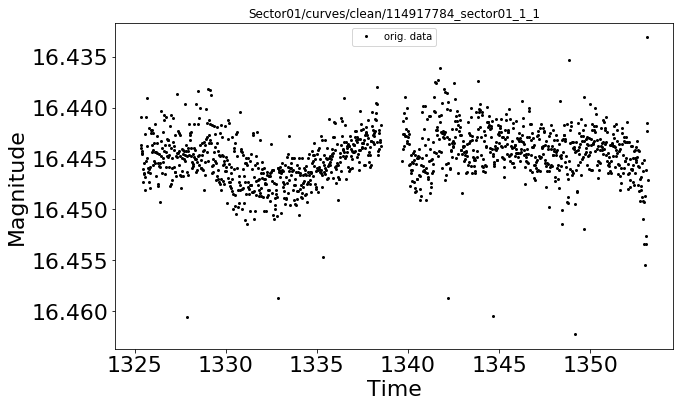

In [3]:
# for d in range(len(data)): #creating a for loop to show light curve figures for all files
for d in range(5): 
    time     = np.transpose(np.loadtxt(data[d]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[d]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[d]))[2] #third (zero indexing in python) column 
    
    plt.figure(figsize=(10,6)) #creating figure
    plt.plot(time,mag,color='black', marker='.',linestyle='none',markersize=ms,label="orig. data") #each data point is a dot, and are not connected by lines
    plt.gca().invert_yaxis()  # remember magnitude is inverted (brightest is more negative, faintest is more positive)
    plt.title(str(data[d][37:-3])) #str = string, the [37:-3] removes the pathname before the filename and the .lc at the end
    plt.xlabel("Time",fontsize=fs)
    plt.ylabel("Magnitude",fontsize=fs)
    plt.xticks(fontsize=fs) #making tick labels bigger than default
    plt.yticks(fontsize=fs)
    plt.legend(loc='upper center')
    plt.show() #shows figure
    print "" #adds space between figures

Let's trying running a rolling mean to get a better idea of what is going on without outliers


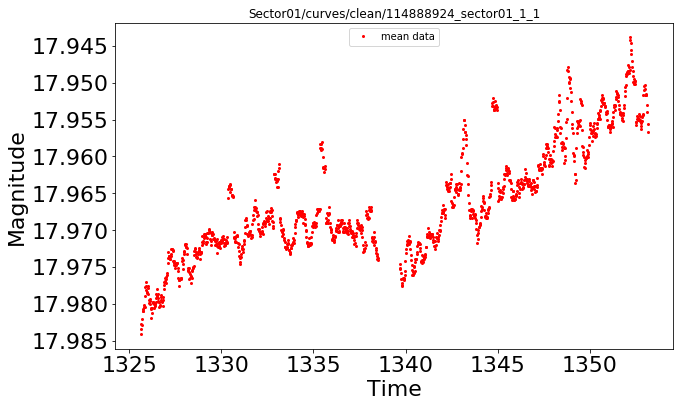

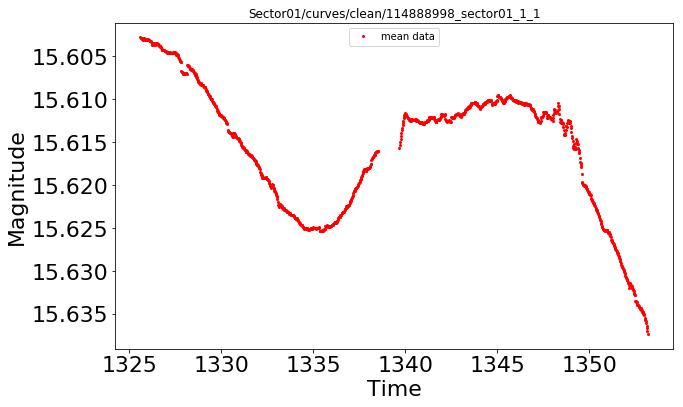

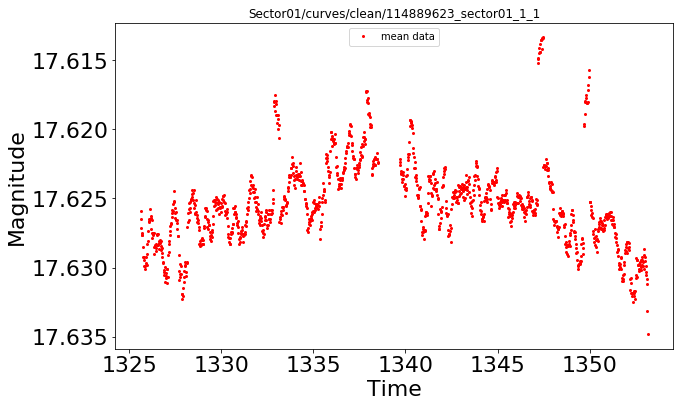

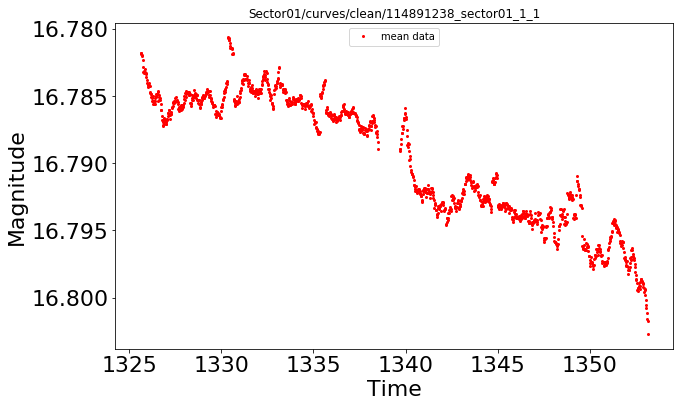

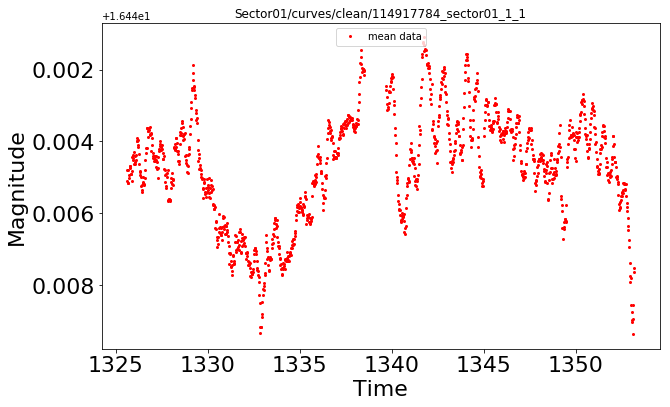

In [4]:
print "Let's trying running a rolling mean to get a better idea of what is going on without outliers"
# https://en.wikipedia.org/wiki/Moving_average

# for d in range(len(data)): #creating a for loop to show light curve figures for all files
for d in range(5): 
    time     = np.transpose(np.loadtxt(data[d]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[d]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[d]))[2] #third (zero indexing in python) column 
    
    mag_mean = np.array(pd.DataFrame(mag).rolling(15).mean()) #allows 15 data points in moving window
    
    plt.figure(figsize=(10,6)) #creating figure
#     plt.plot(time,mag,color='black', marker='.',linestyle='none',markersize=ms,label="orig. data") #each data point is a dot, and are not connected by lines
    plt.plot(time,mag_mean,color='red',marker='.',linestyle='none',markersize=ms,label="mean data") 
    plt.gca().invert_yaxis()  # remember magnitude is inverted (brightest is more negative, faintest is more positive)
    plt.title(str(data[d][37:-3])) #str = string, the [37:-3] removes the pathname before the filename and the .lc at the end
    plt.xlabel("Time",fontsize=fs)
    plt.ylabel("Magnitude",fontsize=fs)
    plt.xticks(fontsize=fs) #making tick labels bigger than default
    plt.yticks(fontsize=fs)
    plt.legend(loc='upper center')    
    plt.show() #shows figure
    print "" #adds space between figures


In [6]:
print ("below doesn't work")
print ("below doesn't work")
print ("below doesn't work")

# binsize = (5./(24.0*60.0)); print binsize

# # for d in range(len(data)): #creating a for loop to show light curve figures for all files
# for d in range(5): 
#     time     = np.transpose(np.loadtxt(data[d]))[0] #first  (zero indexing in python) column 
#     mag      = np.transpose(np.loadtxt(data[d]))[1] #second (zero indexing in python) column 
#     magerror = np.transpose(np.loadtxt(data[d]))[2] #third (zero indexing in python) column 
    
#     mag_mean = np.array(pd.DataFrame(mag).rolling(15).mean())/np.mean(np.array(pd.DataFrame(mag).rolling(15).mean())) #allows 15 data points in moving window

#     bint,binm,binme = Bin_func(time,mag_mean,magerror, binsize) #binning data
    
#     glssinu,glspu = GLS(bint,binm,binme)
#     fit1 = binm-glssinu+1
#     plt.figure(figsize=(10,6))
#     plt.plot(bint,binm,marker='.',linestyle='none',color='grey',zorder=0)
#     plt.plot(bint,glssinu,marker='.',linestyle='none',color='red',zorder=2)
#     plt.plot(bint,fit1,marker='.',linestyle='none',color='black',zorder=1)
#     plt.xlabel("Time")
#     plt.ylabel("Normalized Flux")
#     plt.legend(loc='best') 
#     plt.ylim(0.99,1.01)
#     plt.show()
    
    
    
    
    
    
# #     plt.figure(figsize=(10,6)) #creating figure
# # #     plt.plot(time,mag,color='black', marker='.',linestyle='none',markersize=ms,label="orig. data") #each data point is a dot, and are not connected by lines
# #     plt.plot(time,mag_mean,color='red',marker='.',linestyle='none',markersize=ms,label="mean data") 
# #     plt.gca().invert_yaxis()  # remember magnitude is inverted (brightest is more negative, faintest is more positive)
# #     plt.title(str(data[d][37:-3])) #str = string, the [37:-3] removes the pathname before the filename and the .lc at the end
# #     plt.xlabel("Time",fontsize=fs)
# #     plt.ylabel("Magnitude",fontsize=fs)
# #     plt.xticks(fontsize=fs) #making tick labels bigger than default
# #     plt.yticks(fontsize=fs)
# #     plt.legend(loc='upper center')    
# #     plt.show() #shows figure
# #     print "" #adds space between figures



below doesn't work
below doesn't work
below doesn't work


In [7]:
#savitsky-golay filter
def SG_filt(time,mag,magerror,window_size,polynomial_order,Nsig,binsize):
    from scipy.signal import savgol_filter
    #if clip turned off below
    td=time
    md=mag
    med=magerror
    #clip
    np.savetxt("temp.txt", zip (time,mag,magerror))
#     os.system("vartools -oneline -i temp.txt -clip "+str(Nsig)+" iter -o temp_VTclipped.txt") #iterative sigma clipping
#     d= np.transpose(np.loadtxt("temp_VTclipped.txt"))
#     td  =  d[0]
#     md  =  d[1]
#     med = d[2]
    
    
    #SG filtered
    y = savgol_filter(md,window_size,polynomial_order) #window, polynomial order
    #bin
    import warnings
    warnings.filterwarnings('ignore') #blah blah blah, who needs it?
    bt,bm,bme = Bin_func(td,md,med,binsize)
    
    #clip again
    np.savetxt("temp.txt", zip (bt,bm,bme))
    os.system("vartools -oneline -i temp.txt -clip "+str(Nsig)+" iter -o temp_VTclipped.txt") #iterative sigma clipping
    d= np.transpose(np.loadtxt("temp_VTclipped.txt"))
    td  =  d[0]
    md  =  d[1]
    med = d[2]
    
    return td,md,med

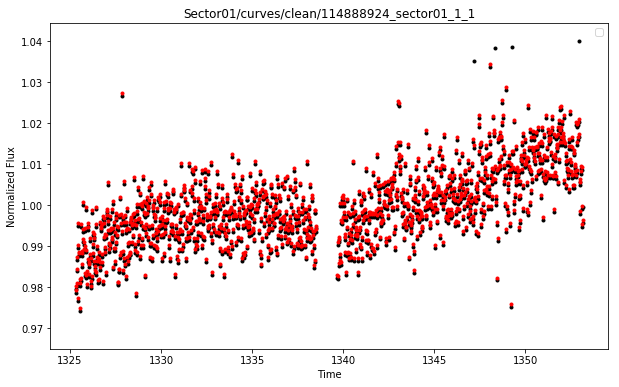

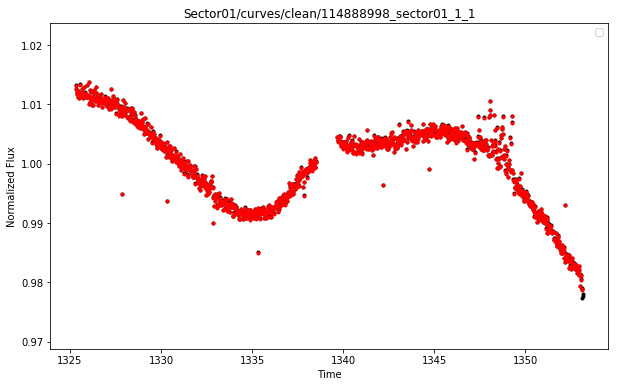

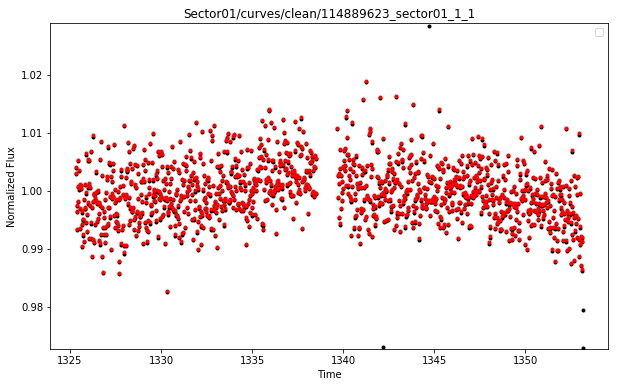

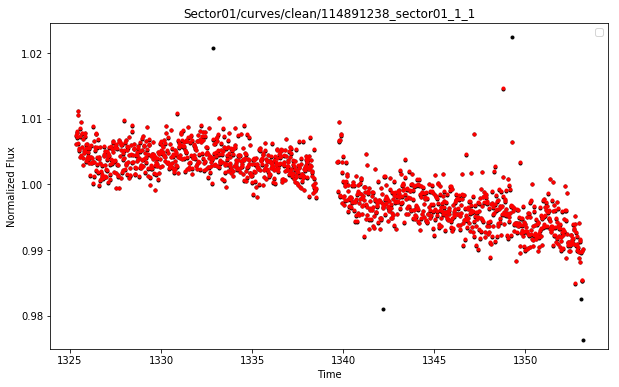

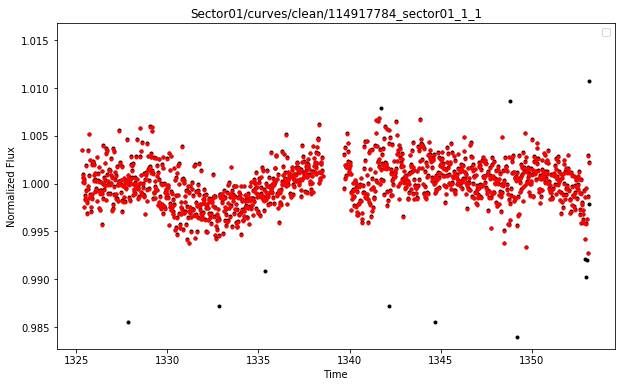

In [9]:
window_size=301;polynomial_order=3;Nsig=3;binsize = (5./(24.0*60.0))



# for d in range(len(data)): #creating a for loop to show light curve figures for all files
for d in range(5): 
    time     = np.transpose(np.loadtxt(data[d]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[d]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[d]))[2] #third (zero indexing in python) column 
    t,m,me = SG_filt(time,mag,magerror,window_size,polynomial_order,Nsig,binsize)
    
    f = 10.0**(m/-2.5)/np.mean(10.0**(m/-2.5))
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    plt.figure(figsize=(10,6))
    plt.plot(time,flux,marker='.',linestyle='none',color='black',zorder=0)
    plt.plot(t,f,marker='.',linestyle='none',color='red',zorder=1)
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.legend(loc='best') 
    plt.ylim(np.min(f)-0.01,np.max(f)+0.01)
    plt.title(str(data[d][37:-3]))
    plt.show()


